In [89]:
# Approach: Linear Regression (Scikit Learn)
# Target Variable (Label): Estimated_value
# R Squared: .84

# Approach: XGBoost 
# Target Variable (Label): Estimated_value
# R Squared: .92

# I thought there were 3 factors that go into housing prices...

# 1: Location, Location, Location
# 2: Size of house and land
# 3: Quality of the house

# I built features to capture these 3 factors

# For Location, Zip Code and Lat-Long pair clusters
# For Size, bedrooms, bathrooms, rooms, squareFootage, lotSize
# For Quality, lastSale_PpSqFt and yearBuilt
# I added lastSaleAmount as an indicator of quality. Teasing out Features related to Quality would be an opportunity for future Feature Developement as my model seems to slightly undershoot very high-end homes ( > 3 million ) ...

#NOTE: The XGBoost portion of the exercise is has been optimized to be particular greedy/CPU intensive to achieve 
#      results. This speed-performance trade-off has been made due to the small size of the dataset. If the reserve
#      dataset is much larger, then either increase VM CPUs/GPUs/RAM or tune the hyper parameters in the 
#      following way:
#           1. Increase learning_rate to >.07
#           2. Reduce max_depth to = 3
#           3. Reduce subsample to > .6

In [180]:
# Import Libraries
import pandas as pd  
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
%matplotlib inline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Upload Data
datafile = "/Users/justinpassek/Downloads/home-values/single_family_home_values.csv"
df = pd.read_csv(datafile)

df.head()



# GCS Bucket

#import gcsfs
#df = pd.read_csv('gs://'+bucket_name+'/'+ filename)



# BigQuery Pull

# Python (will run into a credential issue if not run on a Datalab VM spun up on project with BQ)
#get_ipython().system('pip install --upgrade google-cloud-bigquery')

#from google.cloud import bigquery

#client = bigquery.Client()

#sql = """
#SELECT *
#FROM `project.dataset.table`
#"""
#df = client.query(sql).to_dataframe()
#df.head()

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
0,39525749,8171 E 84th Ave,Denver,CO,80022,39.849160,-104.893468,3,2.0,6,1378,9968,2003.0,2009-12-17,75000,2004-05-13,165700.0,239753
1,184578398,10556 Wheeling St,Denver,CO,80022,39.888020,-104.830930,2,2.0,6,1653,6970,2004.0,2004-09-23,216935,NaN,NaN,343963
2,184430015,3190 Wadsworth Blvd,Denver,CO,80033,39.761710,-105.081070,3,1.0,0,1882,23875,1917.0,2008-04-03,330000,NaN,NaN,488840
3,155129946,3040 Wadsworth Blvd,Denver,CO,80033,39.760780,-105.081060,4,3.0,0,2400,11500,1956.0,2008-12-02,185000,2008-06-27,0.0,494073
4,245107,5615 S Eaton St,Denver,CO,80123,39.616181,-105.058812,3,4.0,8,2305,5600,1998.0,2012-07-18,308000,2011-12-29,0.0,513676


In [181]:
# Explore Target Varia(la)ble

df['estimated_value'].describe()

df.sort_values(by=['estimated_value'], ascending=False)

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
8448,184318691,575 Circle Dr,Denver,CO,80206,39.724562,-104.962436,5,9.0,14,7353,33100,1931.0,2013-03-06,6800000,1998-04-07,2300000.0,10145310
8173,51266875,2109 E 9th Ave,Denver,CO,80206,39.730670,-104.962130,9,8.0,16,10907,42381,1918.0,2010-07-01,4500000,2004-05-04,0.0,9093801
7022,28612816,2025 E 4th Ave,Denver,CO,80206,39.722886,-104.962445,5,7.0,13,5662,36200,1929.0,2008-07-10,5475000,2002-07-03,3000000.0,8424973
13951,51438767,3303 E Kentucky Ave,Denver,CO,80209,39.700009,-104.948047,5,8.0,16,9780,43300,2003.0,2000-08-08,1471500,NaN,NaN,7976662
13293,4277908,3333 E Kentucky Ave,Denver,CO,80209,39.699654,-104.947751,6,9.0,16,8456,20300,2004.0,2005-09-01,4650000,2002-04-15,850000.0,7860355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5760,19591734,3641 N Milwaukee St,Denver,CO,80205,39.767704,-104.952755,2,1.0,4,701,6250,1949.0,2017-05-19,222500,2017-05-16,220000.0,215531
673,184285660,1010 Lowell Blvd,Denver,CO,80204,39.733238,-105.034244,2,1.0,5,1034,7150,1953.0,2016-10-31,120000,1995-08-01,60000.0,214130
2222,184309298,521 Tennyson St,Denver,CO,80204,39.724388,-105.044262,2,1.0,4,674,6650,1946.0,2016-10-07,216000,1977-04-01,19500.0,205776
2116,5094194,601 Meade St,Denver,CO,80204,39.725869,-105.036504,2,1.0,4,664,5710,1927.0,2017-04-14,78000,2007-02-27,57500.0,175963


estimated_value    1.000000
squareFootage      0.824506
bathrooms          0.715926
priorSaleAmount    0.590177
rooms              0.581023
lotSize            0.456539
lastSaleAmount     0.418460
bedrooms           0.369125
yearBuilt          0.174430
id                 0.126193
longitude          0.121984
zipcode            0.089104
latitude          -0.266116
Name: estimated_value, dtype: float64

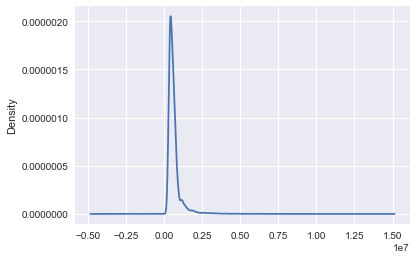

In [182]:
# Understand distribution of Target and find quick correlations 

df['estimated_value'].plot(kind='kde')

data_corr = df.select_dtypes(include=[np.number])
#data_corr.head()

corr = data_corr.corr()
corr.sort_values(['estimated_value'], ascending=False, inplace=True)
corr.head(20)
corr['estimated_value']

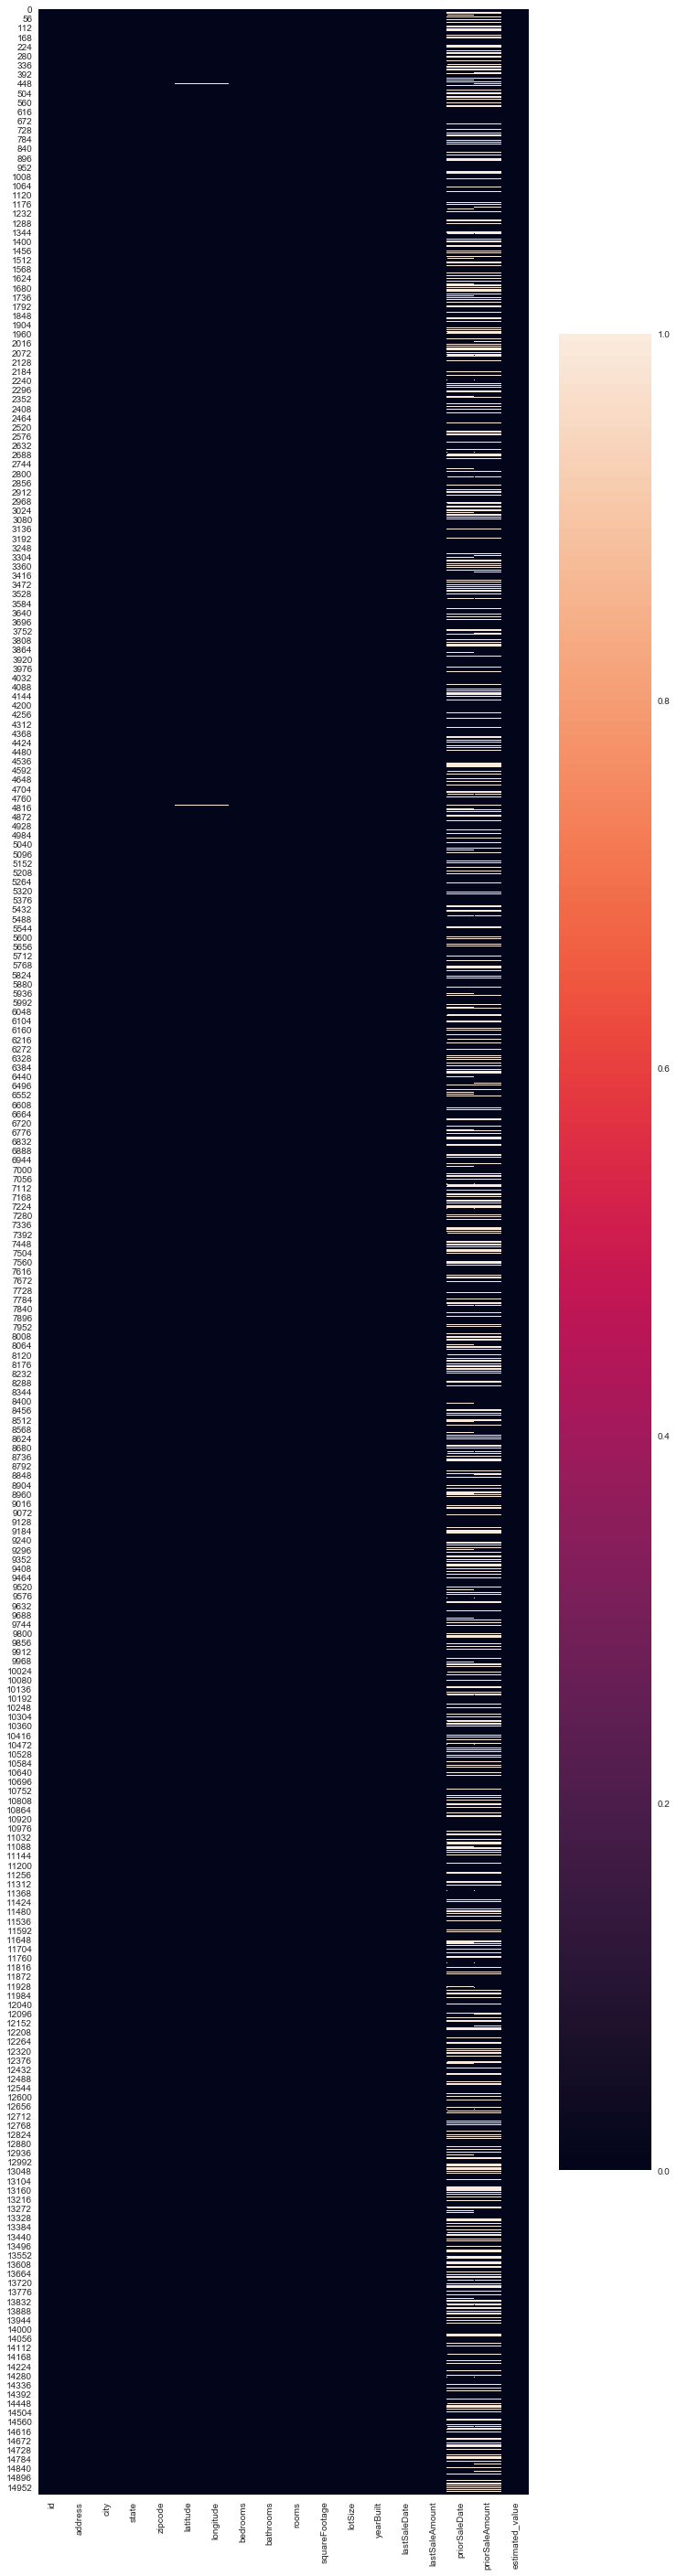

In [183]:
# Look for NA's 
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 50))
sns.heatmap(df.isnull())
plt.show()

In [184]:
# Engineer Possible Features related to past instances of a Sale

df['lastSaleAmount'] = df['lastSaleAmount'].fillna(0)
df['priorSaleAmount'] = df['priorSaleAmount'].fillna(0)

df['no_last_sale_record'] = np.where(df['lastSaleAmount']<1, '1', '0')
df['no_prior_sale_record'] = np.where(df['priorSaleAmount']<1, '1', '0')

df['Yes_last_sale_record'] = np.where(df['lastSaleAmount']==0, '0', '1')
df['Yes_prior_sale_record'] = np.where(df['priorSaleAmount']==0, '0', '1')

df['year_prior_sale'] = pd.to_datetime(df['priorSaleDate']).dt.year
df['year_last_sale'] = pd.to_datetime(df['lastSaleDate']).dt.year


df = df[(df['estimated_value'] < 10000000)]

#print(df)

In [185]:
df.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
print(df)
# Variable with the Longitude and Latitude
X=df.loc[:,['id','latitude','longitude']]
X.head(10)

              id                    address    city state  zipcode   latitude  \
0       39525749            8171 E 84th Ave  Denver    CO    80022  39.849160   
1      184578398          10556 Wheeling St  Denver    CO    80022  39.888020   
2      184430015        3190 Wadsworth Blvd  Denver    CO    80033  39.761710   
3      155129946        3040 Wadsworth Blvd  Denver    CO    80033  39.760780   
4         245107            5615 S Eaton St  Denver    CO    80123  39.616181   
...          ...                        ...     ...   ...      ...        ...   
14995   51411356              802 S High St  Denver    CO    80209  39.701902   
14996   21721153           214 S Lincoln St  Denver    CO    80209  39.712608   
14997   12995320              870 S Race St  Denver    CO    80209  39.700736   
14998   39611615         130 S Lafayette St  Denver    CO    80209  39.714088   
14999   42961679  100 S University Blvd # 1  Denver    CO    80209  39.714399   

        longitude  bedrooms

,id,latitude,longitude
0,39525749,39.849160,-104.893468
1,184578398,39.888020,-104.830930
2,184430015,39.761710,-105.081070
3,155129946,39.760780,-105.081060
4,245107,39.616181,-105.058812
5,3523925,39.615136,-105.069018
6,30560679,39.616350,-105.070760
7,39623928,39.615213,-105.070617
8,148975825,39.620158,-105.063094
9,184623176,39.626770,-105.081990


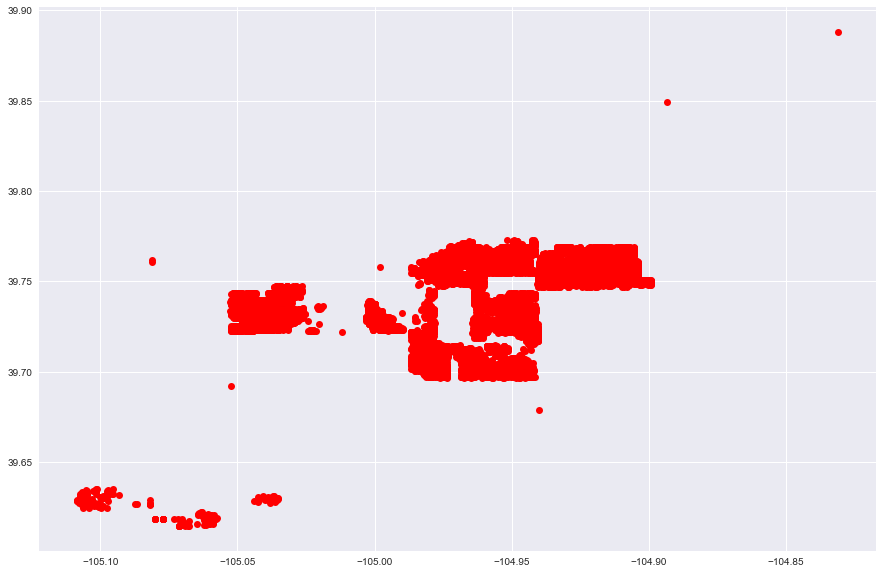

In [186]:
# Plot lat-long data to eye-ball neighborhoods 

#import matplotlib.pyplot as plt
#import matplotlib
#import itertools

#matplotlib.rc('xtick', labelsize=15) 
#matplotlib.rc('ytick', labelsize=15)

fig, ax = plt.subplots(figsize=(15, 10))
plt.style.use('ggplot')
plt.plot(df.longitude, df.latitude, 'ro')

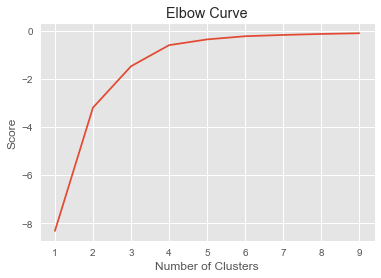

In [187]:
# Use Elbow method to try to identify number of clusters
## NOTE: I ended up going with the 'eye-ball' method as opposed to the 'elbow' method to delineate neighborhoods

K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df[['latitude']]
X_axis = df[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [188]:
# Unstructured clustering model to classify lat-lon pairs into neighborhoods

kmeans = KMeans(n_clusters = 10, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['latlon_cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
print(X)

df = pd.merge(df, X, on='id')

              id   latitude   longitude  latlon_cluster_label
0       39525749  39.849160 -104.893468                     3
1      184578398  39.888020 -104.830930                     3
2      184430015  39.761710 -105.081070                     1
3      155129946  39.760780 -105.081060                     1
4         245107  39.616181 -105.058812                     5
...          ...        ...         ...                   ...
14995   51411356  39.701902 -104.964871                     4
14996   21721153  39.712608 -104.986000                     6
14997   12995320  39.700736 -104.963707                     4
14998   39611615  39.714088 -104.970701                     6
14999   42961679  39.714399 -104.958955                     4

[14984 rows x 4 columns]


In [189]:
# Filling yearBuilt NA values w/ Median

df['yearBuilt'] = df.groupby('latlon_cluster_label')['yearBuilt'].transform(lambda x: x.fillna(x.median()))

In [190]:
# Feature Building

df['lastSaleAmount'] = df.groupby([
    'latlon_cluster_label',
    'year_last_sale'
    ,'bedrooms'
])['lastSaleAmount'].transform(lambda x: x.fillna(x.median()))

df['PpSqFt'] = df['estimated_value'] / df['squareFootage']
df['PpSqFt'] = df.groupby('latlon_cluster_label')['PpSqFt'].transform(lambda x: x.median())

df['lastSale_mean_by_year'] = df.groupby(['year_last_sale',
                                          'latlon_cluster_label']
                                        )['lastSaleAmount'].transform(lambda x: x.fillna(x.mean()))

df['Neigh_Year_lastSale_PpSqFt'] = df['lastSale_mean_by_year'] / df['squareFootage']

df['lastSale_PpSqFt'] = df['lastSaleAmount'] / df['squareFootage']

df['lastSale_above_market'] = np.where(
    df['lastSale_PpSqFt'] - df['Neigh_Year_lastSale_PpSqFt']>0,
    '1',
    '0'
)

df.head()
#print(df)

,id,address,city,state,zipcode,latitude_x,longitude_x,bedrooms,bathrooms,rooms,...,year_prior_sale,year_last_sale,latitude_y,longitude_y,latlon_cluster_label,PpSqFt,lastSale_mean_by_year,Neigh_Year_lastSale_PpSqFt,lastSale_PpSqFt,lastSale_above_market
0,39525749,8171 E 84th Ave,Denver,CO,80022,39.849160,-104.893468,3,2.0,6,...,2004.0,2009,39.849160,-104.893468,3,408.186354,75000,54.426705,54.426705,0
1,184578398,10556 Wheeling St,Denver,CO,80022,39.888020,-104.830930,2,2.0,6,...,NaN,2004,39.888020,-104.830930,3,408.186354,216935,131.237145,131.237145,0
2,184430015,3190 Wadsworth Blvd,Denver,CO,80033,39.761710,-105.081070,3,1.0,0,...,NaN,2008,39.761710,-105.081070,1,351.222172,330000,175.345377,175.345377,0
3,155129946,3040 Wadsworth Blvd,Denver,CO,80033,39.760780,-105.081060,4,3.0,0,...,2008.0,2008,39.760780,-105.081060,1,351.222172,185000,77.083333,77.083333,0
4,245107,5615 S Eaton St,Denver,CO,80123,39.616181,-105.058812,3,4.0,8,...,2011.0,2012,39.616181,-105.058812,5,250.802475,308000,133.622560,133.622560,0


In [191]:
# Drop columns to make DataFrame with relevant Features (iterated)

df = df.drop(['id',
              'address',
              'city',
              'state',
              'latitude_x',
              'longitude_x',
              'latitude_y',
              'longitude_y',
              'lastSaleDate',
#              'lastSaleAmount',
              'priorSaleDate',
              'priorSaleAmount',
#              'yearBuilt',
              'no_last_sale_record',
              'no_prior_sale_record',
              'Yes_last_sale_record',
              'Yes_prior_sale_record',
              'year_prior_sale',
              'year_last_sale',
              'PpSqFt',
              'lastSale_mean_by_year',
              'Neigh_Year_lastSale_PpSqFt'
#              ,'lastSale_above_market'
#              ,'lastSale_PpSqFt'
#              ,'bedrooms'
#              ,'rooms'
             ], axis = 1)

#df = df.fillna(0)

#print(df)

In [192]:
#Scale Continuous Features
from sklearn.preprocessing import StandardScaler 
sc_x = StandardScaler() 

scaled_features = df.copy()
col_names = [
             'bedrooms', 
             'bathrooms',
             'rooms',
             'squareFootage',
             'lotSize',
             'yearBuilt',
             'lastSaleAmount',
             'lastSale_PpSqFt'
            ]
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features
df = scaled_features
df.head()

#remove outliers
#from scipy import stats
#df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

,zipcode,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleAmount,estimated_value,latlon_cluster_label,lastSale_PpSqFt,lastSale_above_market
0,80022,0.325895,-0.166690,-0.083185,-0.163571,1.380268,2.459708,-0.425992,239753,3,-0.285964,0
1,80022,-0.789758,-0.166690,-0.083185,0.168224,0.382732,2.493168,-0.242664,343963,3,-0.183038,0
2,80033,0.325895,-1.025886,-3.150737,0.444519,6.007597,-0.417816,-0.096626,488840,1,-0.123933,0
3,80033,1.441548,0.692506,-3.150737,1.069500,1.890017,0.887108,-0.283913,494073,1,-0.255605,0
4,80123,0.325895,1.551702,0.939332,0.954880,-0.073113,2.292410,-0.125042,513676,5,-0.179842,0


In [193]:
# One-hot encode categorical features
# label encoding the data 

df['zipcode'] = df['zipcode'].astype(object)
df['latlon_cluster_label'] = df['latlon_cluster_label'].astype(object)
#df['lastSale_above_market'] = df['lastSale_above_market'].astype(object)

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

df = encode_and_bind(df, 'zipcode')
df = encode_and_bind(df, 'latlon_cluster_label')
df = encode_and_bind(df, 'lastSale_above_market')

df.head()
#print(df)

,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleAmount,estimated_value,lastSale_PpSqFt,zipcode_80022,...,latlon_cluster_label_1,latlon_cluster_label_2,latlon_cluster_label_3,latlon_cluster_label_4,latlon_cluster_label_5,latlon_cluster_label_6,latlon_cluster_label_7,latlon_cluster_label_8,latlon_cluster_label_9,lastSale_above_market_0
0,0.325895,-0.166690,-0.083185,-0.163571,1.380268,2.459708,-0.425992,239753,-0.285964,1,...,0,0,1,0,0,0,0,0,0,1
1,-0.789758,-0.166690,-0.083185,0.168224,0.382732,2.493168,-0.242664,343963,-0.183038,1,...,0,0,1,0,0,0,0,0,0,1
2,0.325895,-1.025886,-3.150737,0.444519,6.007597,-0.417816,-0.096626,488840,-0.123933,0,...,1,0,0,0,0,0,0,0,0,1
3,1.441548,0.692506,-3.150737,1.069500,1.890017,0.887108,-0.283913,494073,-0.255605,0,...,1,0,0,0,0,0,0,0,0,1
4,0.325895,1.551702,0.939332,0.954880,-0.073113,2.292410,-0.125042,513676,-0.179842,0,...,0,0,0,0,1,0,0,0,0,1


In [194]:
# Split test & train, and target variable

X = df.drop('estimated_value', axis = 1)
y = df['estimated_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.head()
y_train.head()

13964    648421
8031     465076
3078     230972
14211    639602
12749    360431
Name: estimated_value, dtype: int64

In [195]:
# Define and fit model

from sklearn import linear_model
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)

In [196]:
# Pull out coefficients to understand impact of Features

coeff_df = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
bedrooms,-6.837869e+04
bathrooms,6.681409e+04
rooms,-2.006067e+04
squareFootage,2.697784e+05
lotSize,8.228423e+04
yearBuilt,2.193096e+04
lastSaleAmount,2.396612e+05
lastSale_PpSqFt,-1.924412e+05
zipcode_80022,7.775883e+04
zipcode_80033,-5.827661e+05


In [197]:
# Make Predictions

y_pred = lm.predict(X_test)

In [198]:
# Compare predictions w/ Table

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)
df1
df

df.sort_values(by=['Actual'], ascending=False)

,Actual,Predicted
13426,6538208,6.456397e+06
7749,5740811,3.684011e+06
7175,5613580,3.340043e+06
7055,5204393,5.202214e+06
8413,4826309,3.041009e+06
...,...,...
2795,229491,2.262918e+05
2805,222605,1.205330e+05
1269,221404,1.659618e+05
2536,220948,2.538265e+05


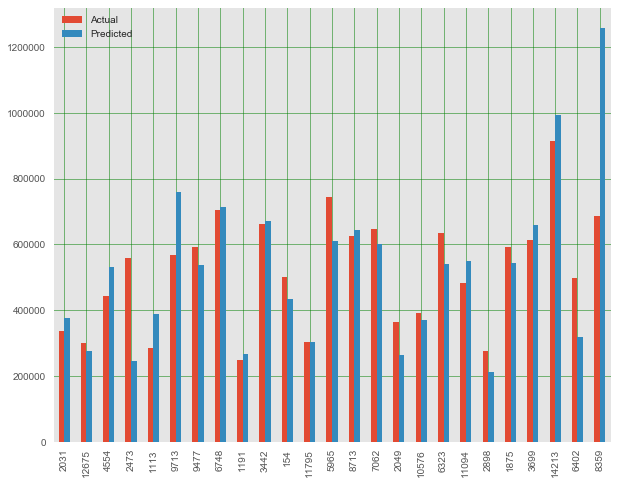

In [199]:
# Bar Chart of Predictions

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

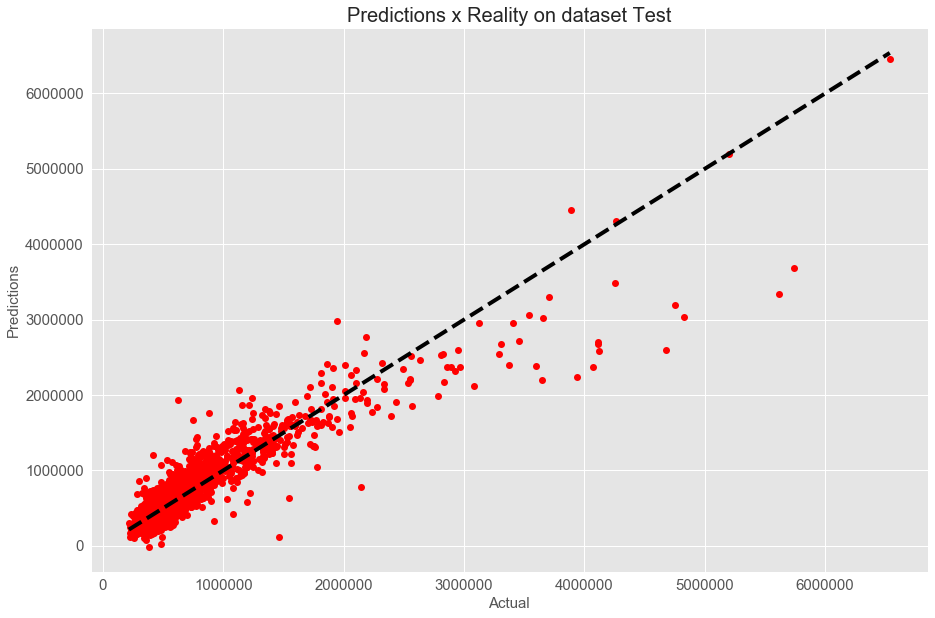

In [200]:
# Plot Predictions

predictions = df

import matplotlib.pyplot as plt
import matplotlib
import itertools

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

fig, ax = plt.subplots(figsize=(15, 10))
plt.style.use('ggplot')
plt.plot(predictions.Actual, predictions.Predicted, 'ro')
plt.xlabel('Actual', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.title('Predictions x Reality on dataset Test', fontsize = 20)
ax.plot([df.Actual.min(), df.Actual.max()], [df.Actual.min(), df.Actual.max()], 'k--', lw=4)
ax.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [201]:
# Print Errors

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print('R Squared Score:', lm.score(X_test, y_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, y_pred))

Mean Absolute Error: 116014.92852087975
Mean Squared Error: 38309972102.99089
Root Mean Squared Error: 195729.3337826267
Coefficient of determination (R^2): 0.84


In [223]:
# Trying with XGBoost

import sys
!{sys.executable} -m pip install xgboost
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

regressor = xgboost.XGBRegressor(colsample_bytree=0.4,    #.4percentage of features used per tree. High value can lead to overfitting.
                 gamma=0,                 
                 learning_rate=0.01,     #.01step size shrinkage used to prevent overfitting. Range is [0,1]
                 max_depth=5,            #5 Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
                 min_child_weight=1,     #1.5In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
                 n_estimators=10000,     #number of trees you want to build                                                               
                 reg_alpha=1,            #1 L1 regularization on leaf weights. A large value leads to more regularization
                 reg_lambda=0.6,         #.6 L2 regularization on leaf weights and is smoother than L1 regularization
                 subsample=1,            #.1 percentage of samples used per tree. Low value can lead to underfitting
                 seed=42)
regressor.fit(X_train,y_train)

You should consider upgrading via the 'pip install --upgrade pip' command.
[15:02:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=1, reg_lambda=0.6, scale_pos_weight=1, seed=42,
       silent=None, subsample=1, verbosity=1)

In [224]:
Y_pred_train = regressor.predict(X_train)
y_pred = regressor.predict(X_test)

In [226]:
df_xg = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1_xg = df.head(25)
df1_xg
df_xg

df_xg.sort_values(by=['Actual'], ascending=False)

,Actual,Predicted
13426,6538208,7.037652e+06
7749,5740811,4.973692e+06
7175,5613580,4.222102e+06
7055,5204393,6.134376e+06
8413,4826309,4.862522e+06
...,...,...
2795,229491,2.687816e+05
2805,222605,2.920160e+05
1269,221404,2.778696e+05
2536,220948,3.286816e+05


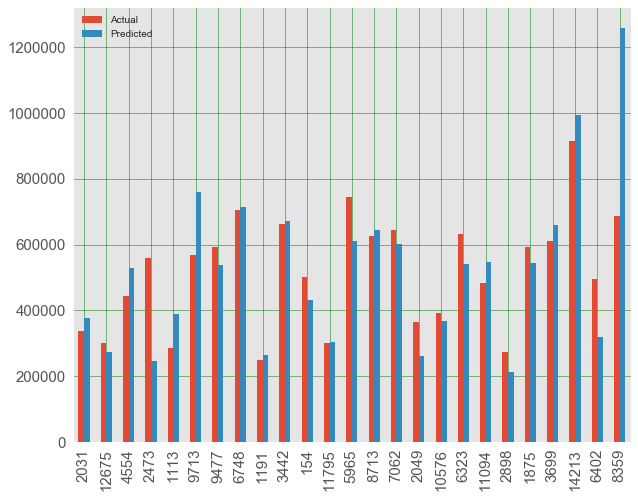

In [227]:
# Bar Chart of Predictions XG

df1_xg.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

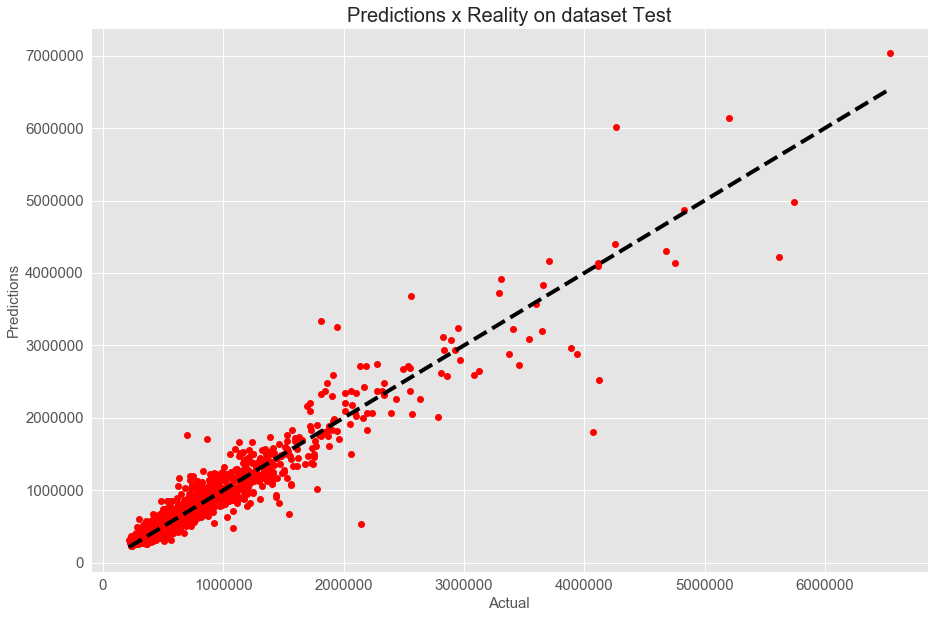

In [228]:
# Plot Predictions XG

predictions = df_xg

import matplotlib.pyplot as plt
import matplotlib
import itertools

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

fig, ax = plt.subplots(figsize=(15, 10))
plt.style.use('ggplot')
plt.plot(predictions.Actual, predictions.Predicted, 'ro')
plt.xlabel('Actual', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.title('Predictions x Reality on dataset Test', fontsize = 20)
ax.plot([df.Actual.min(), df.Actual.max()], [df.Actual.min(), df.Actual.max()], 'k--', lw=4)
ax.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [229]:
# Print Errors

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print('R Squared Score:', lm.score(y_test, y_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, y_pred))

Mean Absolute Error: 67426.52296567401
Mean Squared Error: 19573613197.7462
Root Mean Squared Error: 139905.72968161883
Coefficient of determination (R^2): 0.92
